In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(0, "python")
from network import *
from protocols import *
from adversary import *
from simulator import *

# Dandelion example

In [3]:
net = Network(400, 40, edge_weight="normal")

In [4]:
dp = DandelionProtocol(net, 0.5)

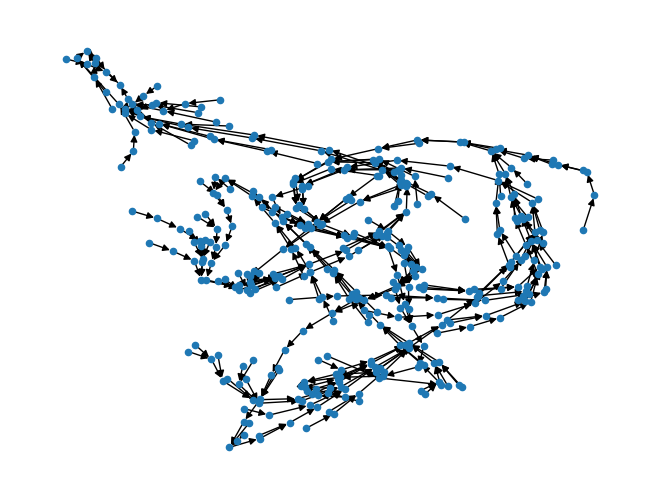

In [5]:
nx.draw(dp.line_graph, node_size=20)

In [6]:
%%time
adv = Adversary(net, 0.1)
sim = Simulator(dp, adv, 10, verbose=False)
sim.run(coverage_threshold=0.95)

CPU times: user 1.15 s, sys: 31.2 ms, total: 1.18 s
Wall time: 1.19 s


In [7]:
%%time
evaluator = Evaluator(sim, "first_reach")
print(evaluator.get_report())

{'estimator': 'first_reach', 'hit_ratio': 0.1, 'inverse_rank': 0.1135189026816811, 'entropy': 0.0, 'ndcg': 0.23534640318166739, 'message_spread_ratio': 0.7540000000000001}
CPU times: user 23.2 ms, sys: 2.6 ms, total: 25.8 ms
Wall time: 20.5 ms


In [8]:
%%time
evaluator = Evaluator(sim, "shortest_path")
print(evaluator.get_report())

{'estimator': 'shortest_path', 'hit_ratio': 0.1, 'inverse_rank': 0.1624619404868367, 'entropy': 5.7090331893714135, 'ndcg': 0.2884457164888198, 'message_spread_ratio': 0.7540000000000001}
CPU times: user 251 ms, sys: 20.7 ms, total: 272 ms
Wall time: 270 ms


In [9]:
%%time
evaluator = Evaluator(sim, "dummy")
print(evaluator.get_report())

{'estimator': 'dummy', 'hit_ratio': 0.0, 'inverse_rank': 0.015291373082491807, 'entropy': 5.886104031450157, 'ndcg': 0.1509309584531365, 'message_spread_ratio': 0.7540000000000001}
CPU times: user 47.7 ms, sys: 63 µs, total: 47.8 ms
Wall time: 45.2 ms


# Experiment example

In [10]:
def run_and_eval(net: Network, adv: Adversary, protocol: Protocol):
    sim = Simulator(protocol, adv, int(network_size / 10), verbose=True)#False)
    sim.run()
    evaluator = Evaluator(sim)
    report = evaluator.get_report()
    report["protocol"] = str(protocol)
    report["adversary_ratio"] = adv.ratio
    return report, sim

In [11]:
network_size = 1000
degree = 50
num_trials = 10
adversary_ratios = [0.01,0.05]#[0.01,0.025,0.05,0.075,0.1]
results = []

### Should we use dijkstra instead?
Yes - but then adaptive adversaries are out of the question...

### Still very slow: 
- 1 broadcast experiment: 33 sec (if only first contact is considered) and 35 sec if more contact is considered
- **TODO:** do profiling...

In [12]:
from tqdm.notebook import tqdm

In [15]:
%%time
# it could be parallelized
for adv_ratio in adversary_ratios:
    for _ in tqdm(range(num_trials)):
        # this part cannot be parallelized: it is important that different protocols will be evaluated with the same network and adversary setting
        net = Network(network_size, degree)
        adv = Adversary(net, adv_ratio)
        # BUT: messages won't be the same!!!
        protocols = [
            #BroadcastProtocol(net),
            DandelionProtocol(net, 0.5),
            #DandelionProtocol(net, 0.25)
        ]
        for protocol in protocols:
            report, sim = run_and_eval(net, adv, protocol)
            results.append(report)
        break
    break
    print(adv_ratio)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 36.5 s, sys: 1.93 s, total: 38.4 s
Wall time: 38.1 s


### Number of messages is incredibely high!
if one node already broadcasted the message then do so no longer...
still slow...

In [14]:
len(sim.messages[0].queue)

29665

In [ ]:
import seaborn as sns

In [15]:
results_df = pd.DataFrame(results)
results_df.head()

,estimator,hit_ratio,inverse_rank,entropy,ndcg,message_spread_ratio,protocol,adversary_ratio
0,first_reach,0.04,0.046258,0.0,0.160076,0.43135,BroadcastProtocol(),0.01


### Dummy adversary predicts message source for Dandelion much worse than in case of ismple broadcasting

<AxesSubplot: xlabel='adversary_ratio', ylabel='entropy'>

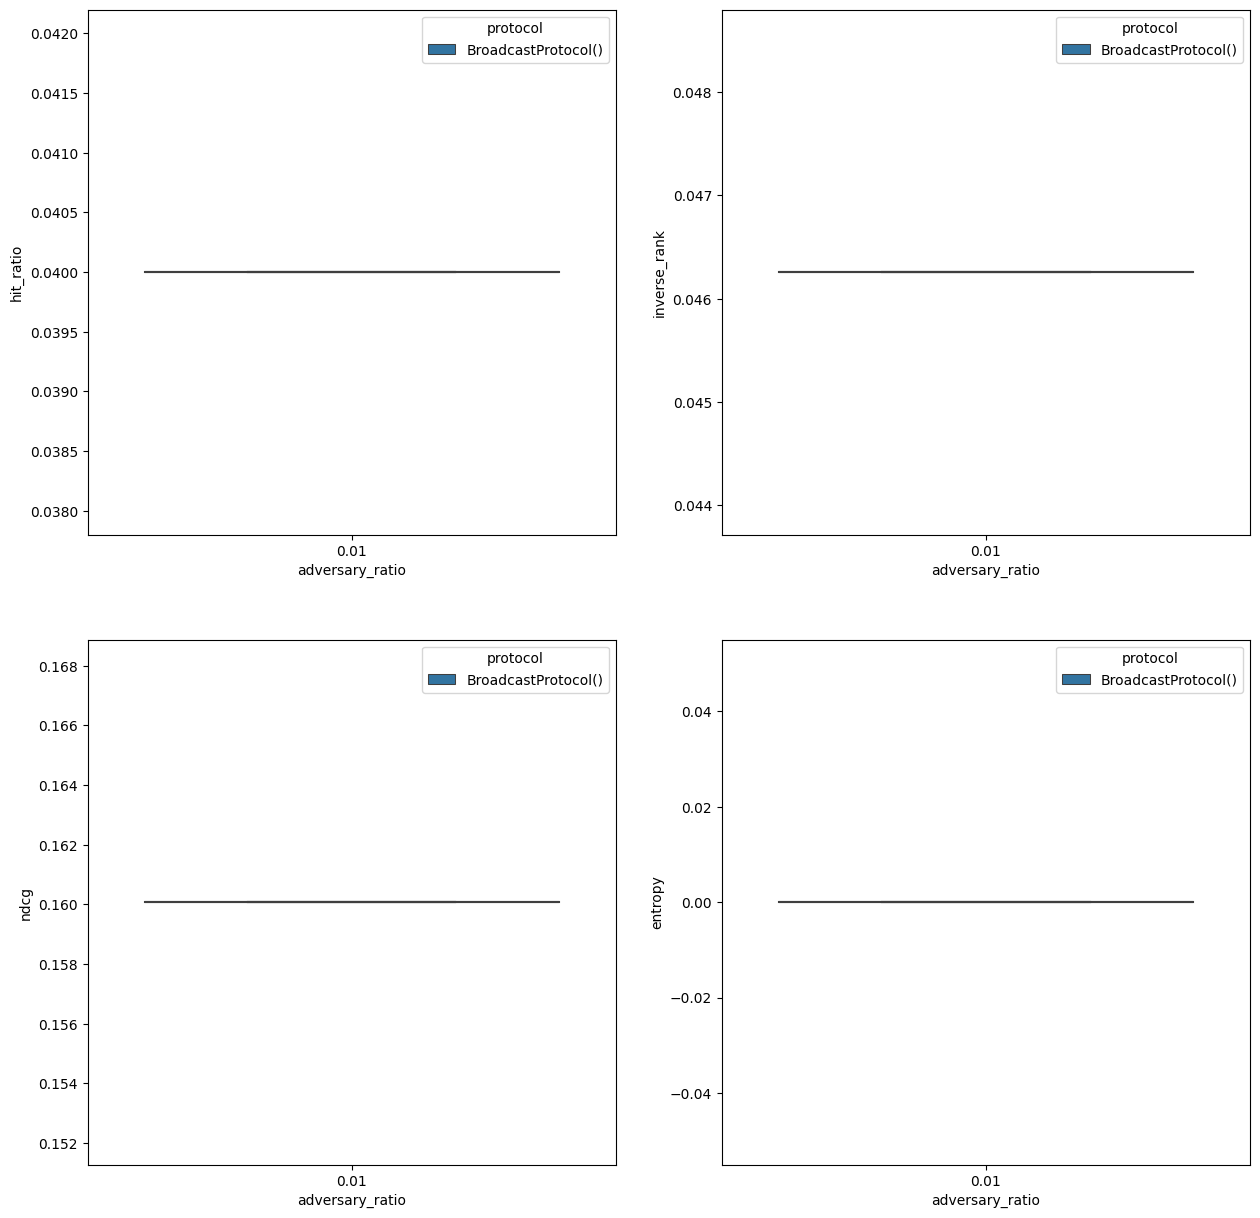

In [16]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
sns.boxplot(data=results_df, x="adversary_ratio", y="hit_ratio", hue="protocol", ax=ax[0][0])
sns.boxplot(data=results_df, x="adversary_ratio", y="inverse_rank", hue="protocol", ax=ax[0][1])
sns.boxplot(data=results_df, x="adversary_ratio", y="ndcg", hue="protocol", ax=ax[1][0])
sns.boxplot(data=results_df, x="adversary_ratio", y="entropy", hue="protocol", ax=ax[1][1])

### While the fraction of nodes reached by messages are the same range for all protocols

<AxesSubplot: xlabel='adversary_ratio', ylabel='message_spread_ratio'>

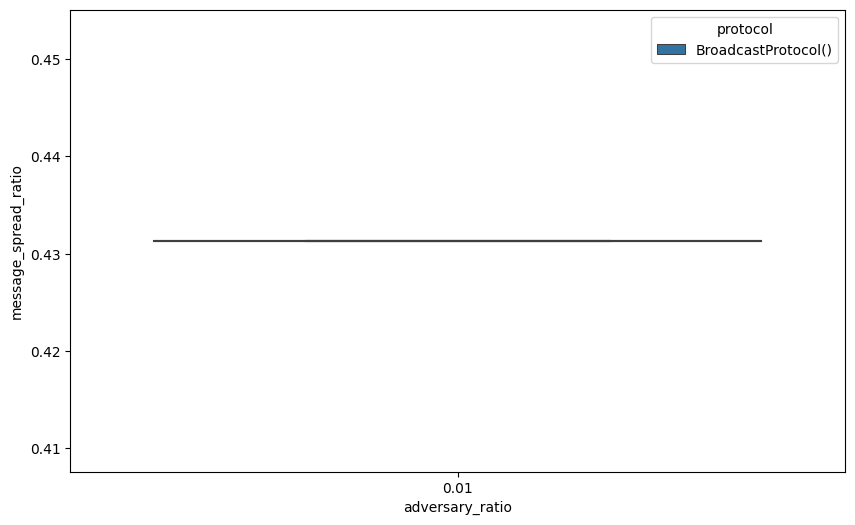

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.boxplot(data=results_df, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax)